In [1]:
import jax
import jax.random as jr
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
from frugal_flows.causal_flows import get_independent_quantiles, train_frugal_flow

from frugal_flows.bijections import UnivariateNormalCDF

In [2]:
jax.config.update("jax_enable_x64", True)

In [21]:
data_path = '/Users/llaurabat/Dropbox/Oxford/deep_copula_frugal/deep-copula-frugal/data/'

df = pd.read_csv(data_path + 'data_xdyc.csv')
cols = [i for i in df.columns if i not in ['Z1', 'Z2']]
df = df[cols].copy()

In [22]:
df.groupby('X').mean()

,Y,Z3,Z4
X,,,
0.0,0.370500,-0.727174,0.071282
1.0,0.068882,0.122008,-0.094613


In [23]:
df.loc[df['X']==0, ['Z3', 'Z4']].corr()

,Z3,Z4
Z3,1.000000,0.801955
Z4,0.801955,1.000000


In [24]:
df.loc[df['X']==1, ['Z3', 'Z4']].corr()

,Z3,Z4
Z3,1.000000,0.770474
Z4,0.770474,1.000000


In [25]:
df.groupby('X').std()

,Y,Z3,Z4
X,,,
0.0,1.079367,0.938478,1.019502
1.0,1.135010,1.026536,1.040143


In [26]:
vmapped_normal_cdf = jax.vmap(UnivariateNormalCDF(ate=0., const=0., scale=1.).transform)

In [27]:
u_z3 = vmapped_normal_cdf(df['Z3'].values)
u_z4 = vmapped_normal_cdf(df['Z4'].values)

In [28]:
jnp.vstack([u_z3, u_z4]).T.shape

(1000, 2)

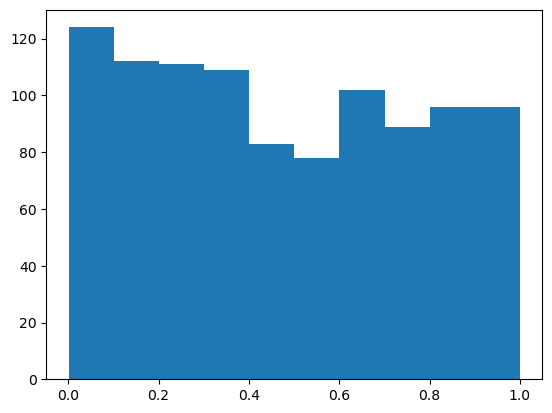

In [29]:
plt.hist(u_z4);

In [30]:
res = get_independent_quantiles(key = jr.PRNGKey(78),
                                z_cont=jnp.array(df[['Z3', 'Z4']].values),
                                learning_rate=1e-3,
                                max_epochs = 70,
                                max_patience=10,
                                return_z_cont_flow = True,
                             )

 34%|███████████████████▉                                      | 24/70 [00:05<00:10,  4.18it/s, train=2.8825890385695385, val=3.149861806349252 (Max patience reached)]


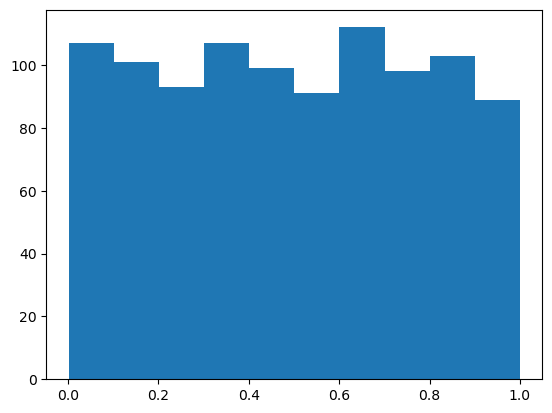

In [31]:
plt.hist(res['u_z_cont'][:,1]);

In [32]:
jnp.array(df['Y'].values)

Array([-3.41933910e-01, -2.94930173e-01,  7.58104635e-01,  5.55621351e-01,
        1.13509265e+00, -3.82535462e-01, -5.92392725e-01,  7.43922173e-01,
        8.36544312e-01,  2.32177349e-01, -1.00615034e+00,  1.16218038e+00,
        4.42906169e-01, -1.56186211e-01, -1.10737972e+00,  1.21664187e+00,
       -1.49412466e+00, -8.91364170e-01, -7.71570898e-01, -1.37572906e-01,
        1.99105883e+00,  1.81887852e+00, -4.23753223e-01, -8.26243691e-01,
       -1.04645356e+00,  1.28740611e+00, -1.14520029e+00, -8.01495083e-01,
        1.86019210e+00, -5.25570643e-01,  2.15231463e+00,  9.30652962e-01,
        4.41138548e-01,  2.54784920e-01, -2.24606669e+00,  4.98915547e-01,
       -5.48957879e-01, -2.54445743e+00, -1.25901119e-01, -7.83924059e-01,
       -5.87054617e-01, -7.92392753e-02,  1.18652591e+00,  4.29691543e-01,
        8.81342938e-01, -3.33700529e-02, -5.68309534e-01,  7.66220404e-01,
        1.54384876e+00, -3.02563683e+00,  9.02494708e-02,  5.79873354e-01,
        2.18985800e+00, -

In [33]:
frugal_flow, losses =  train_frugal_flow(key=jr.PRNGKey(90),
                y=jnp.array(df['Y'].values)[:,None],
                u_z=jnp.vstack([u_z3, u_z4]).T,
                RQS_knots=8,
                show_progress=True,
                learning_rate=1e-2,
                max_epochs=500,
                max_patience=30,
                batch_size=100,
                condition=jnp.array(df['X'].values)[:,None],
             )

 47%|█████████████████████████▋                             | 233/500 [00:17<00:19, 13.40it/s, train=0.9225846715830746, val=1.3387526625421464 (Max patience reached)]


In [34]:
k1, k2 = jr.split(jr.PRNGKey(970), 2)
frugal_flow_samples_0 = frugal_flow.sample(k1, condition=jnp.zeros((1000,1))) #
frugal_flow_samples_1 = frugal_flow.sample(k2, condition=jnp.ones((1000,1))) #

In [35]:
frugal_flow_samples_0.shape

(1000, 3)

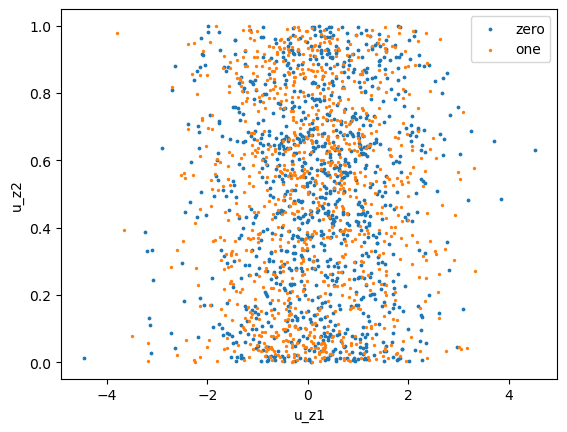

In [39]:
plt.scatter(*frugal_flow_samples_0[:,1:].T, label="zero", s=3)
plt.scatter(*frugal_flow_samples_1[:,1:].T, label="one", s=2)
plt.xlabel('u_z1')
plt.ylabel('u_z2')
plt.legend()
plt.show()

In [43]:
flow_fake_condition = jnp.zeros((1000,1))
n_samples = 1000
flow_dim = 3
key = jr.PRNGKey(7)

uni_standard = jr.uniform(key, shape=(n_samples, flow_dim))
uni_minus1_plus1 = jax.vmap(frugal_flow.bijection.bijections[0].tree.transform)(uni_standard)

corruni_minus1_plus1 = jax.vmap(frugal_flow.bijection.bijections[1].transform)(uni_minus1_plus1, flow_fake_condition)
corruni_standard = jax.vmap(frugal_flow.bijection.bijections[2].tree.transform)(corruni_minus1_plus1, flow_fake_condition)
us = corruni_standard

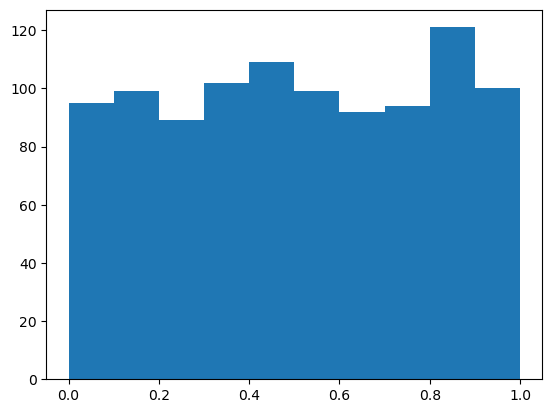

In [42]:
plt.hist(u_y);

In [47]:
jnp.cov(us.T)

Array([[0.08361634, 0.00743443, 0.00407311],
       [0.00743443, 0.0906976 , 0.0620112 ],
       [0.00407311, 0.0620112 , 0.08807252]], dtype=float64)

In [ ]:
plt.scatter(*frugal_flow_samples_0[:,1:].T, label="zero", s=3)
plt.scatter(*frugal_flow_samples_1[:,1:].T, label="one", s=2)
plt.xlabel('u_z1')
plt.ylabel('u_z2')
plt.legend()
plt.show()

In [37]:
frugal_flow.bijection.bijections[-1].bijection.bijections[0].ate

Array(-0.09629526, dtype=float64)

In [38]:
frugal_flow.bijection.bijections[-1].bijection.bijections[0].const

Array(0.19348669, dtype=float64)